In [5]:
import os
import datasets
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from onnxruntime import InferenceSession
import joblib
import tf2onnx
import subprocess

In [4]:
!pip install onnxruntime tf2onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 451.2/451.2 kB 8.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.1.21
    Uninstalling flatbuffers-23.1.21:
      Successfully uninstalled flatbuffers-23.1.21
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflow-serving-api 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.


In [6]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from transformers import ViTFeatureExtractor
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import img_to_array
from transformers import DefaultDataCollator
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import VGG19
from keras.applications.efficientnet_v2 import EfficientNetV2M
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics  import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
df = pd.read_csv("/kaggle/input/art-price-dataset/artDataset.csv")
df["image"] = [f'image_{i}.png' for i in range(1, len(df) + 1)]

images = list(os.walk("/kaggle/input/art-price-dataset/artDataset"))[0][2]
prices = df.set_index("image").loc[images].price.map(lambda x: int(x.strip(" USD").replace(".", ""))).values


images_arrays = []
for i in images:
    img = load_img(f"/kaggle/input/art-price-dataset/artDataset/{i}", target_size=(224, 224, 3)) 
    images_arrays.append(img_to_array(img))
    
images_arrays = np.concatenate([i.reshape(1, 224, 224, 3) for i in images_arrays])
images_arrays = images_arrays.astype('uint8')
images_arrays.shape

(754, 224, 224, 3)

In [8]:
def rmsle(y_true, y_pred):
    return 'RMSLE', np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))), False

In [18]:
def get_features(images, model, weights: str): 
    base_model = model(weights=weights, include_top=False)
    x = base_model.output
    x = keras.layers.GlobalAveragePooling2D()(x)
    predictions = x

    # this is the model we will train
    model = keras.Model(inputs=base_model.input, outputs=predictions)
    features = model.predict(images)
    return features, model

def train_boosting(X_train, y_train, params): 
    lgb = LGBMRegressor(**params)
    
    lgb.fit(X_train, np.log1p(y_train), eval_metric=rmsle,)
    return lgb

def test_boosting(X_test, y_test, lgb,):
    pred = lgb.predict(X_test, num_iteration=lgb.best_iteration_)

    print("mse: ", mean_squared_error(y_test,  np.expm1(pred)))
    print("mae: ", mean_absolute_error(y_test,  np.expm1(pred)))
    print("msle: ", mean_squared_log_error(y_test,  np.expm1(pred)))
    print("rmsle: ", rmsle(y_test,  np.expm1(pred)))

In [11]:
features_inc, model_inc = get_features(images_arrays, InceptionV3, 'imagenet')

24/24 [==============================] - 43s 2s/step


In [12]:
X_train, X_test, y_train, y_test = train_test_split(features_inc, prices, test_size=0.2, random_state=19)

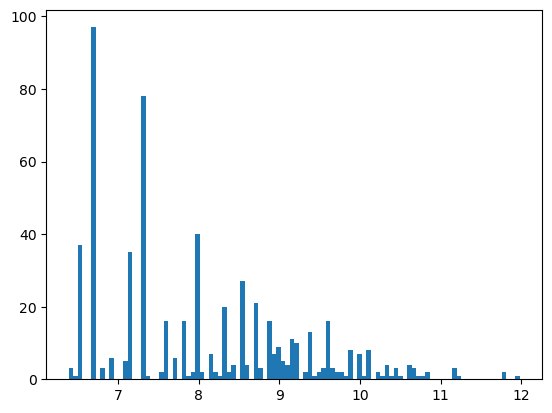

In [14]:
plt.hist(np.log1p(y_train), bins=100);

In [15]:
opt_params = {'feature_fraction': 0.8,
                 'learning_rate': 0.1,
                 'max_bin': 25,
                 'max_depth': 15,
                 'min_data_in_leaf': 30,
                 'min_sum_hessian_in_leaf': 85,
                 'objective': 'regression',
                 'metric': 'rmsle',
                 'boost_from_average': True}

In [16]:
lgb = train_boosting(X_train, y_train, opt_params)
test_boosting(X_test, y_test, lgb)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=85, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=85
mse:  68338744.7793844
mae:  4056.949823684853
msle:  0.8895957516073937
rmsle:  ('RMSLE', 0.9431838376517028, False)


In [20]:
features_vgg, model_vgg = get_features(images_arrays, VGG19, 'imagenet')
X_train, X_test, y_train, y_test = train_test_split(features_vgg, prices, test_size=0.2, random_state=19)
lgb = train_boosting(X_train, y_train, opt_params)
test_boosting(X_test, y_test, lgb)

24/24 [==============================] - 257s 11s/step
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=85, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=85
mse:  59030834.06850949
mae:  3950.1530023467217
msle:  0.7082120872901715
rmsle:  ('RMSLE', 0.8415533775644725, False)


In [21]:
# convert to onnx model
if not os.path.exists("vgg19"):
    os.mkdir("vgg19")
tf.keras.models.save_model(model_vgg, "vgg19")

########################################
# Run the command line.
proc = subprocess.run('python -m tf2onnx.convert --saved-model vgg19 '
                      '--output vgg19.onnx --rename-inputs input0 --opset 13'.split(),
                      capture_output=True)
print(proc.returncode)
print(proc.stdout.decode('ascii'))
print(proc.stderr.decode('ascii'))

0

/opt/conda/lib/python3.7/runpy.py:125: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2023-04-14 09:18:45,262 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-04-14 09:18:46,059 - INFO - Signatures found in model: [serving_default].
2023-04-14 09:18:46,059 - WARNING - '--signature_def' not specified, using first signature: serving_default
2023-04-14 09:18:46,059 - INFO - Output names: ['global_average_pooling2d_2']
2023-04-14 09:18:50,054 - INFO - Using tensorflow=2.11.0, onnx=1.13.1, tf2onnx=1.14.0/8f8d49
2023-04-14 09:18:50,054 - INFO - Using opset <onnx, 13>
2023-04-14 09:18:50,367 - INFO - Computed 0 values for constant folding
2023-04-14 09:18:51,240 - INFO - Optimizing ONNX model
2023-04-14 09:18:51,572 - INFO - After optimization: GlobalAveragePool +1 (0->1), Identity -2 (2->0), ReduceMean -1 (1

In [407]:
lgbr = LGBMRegressor(**opt_params)
lgbr.fit(features, np.log1p(prices), eval_metric=rmsle,)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=85, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=85


LGBMRegressor(boost_from_average=True, feature_fraction=0.8, max_bin=25,
              max_depth=15, metric='rmsle', min_data_in_leaf=30,
              min_sum_hessian_in_leaf=85, objective='regression')

In [408]:
pred = lgbr.predict(X_test, num_iteration=lgbr.best_iteration_)

print("mse: ", mean_squared_error(y_test,  np.expm1(pred)))
print("mae: ", mean_absolute_error(y_test,  np.expm1(pred)))
print("msle: ", mean_squared_log_error(y_test,  np.expm1(pred)))
print("rmsle: ", rmsle(y_test,  np.expm1(pred)))

mse:  33195362.25791167

mae:  2464.6246009679076

msle:  0.20124575653610385

rmsle:  ('RMSLE', 0.448604231518277, False)


In [4]:
import joblib

In [410]:
joblib.dump(lgbr, 'lgb.pkl')

['lgb.pkl']

In [35]:
lg = joblib.load('lgb.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'lgb.pkl'

In [6]:
from onnxruntime import InferenceSession
session = InferenceSession("vgg19.onnx")

In [21]:
img = np.random.randn(50, 100, 3).astype(np.float32)

In [440]:
preds = []

for i, img in enumerate(images_arrays[:10]):
    features = session.run(None, {'input0': np.expand_dims(img.astype('float32'), 0)})
    price = np.expm1(lg.predict(features[0]))[0] 
    price = price if price < 10000 else price * 1.5
    print(price)

7077.667202753905

1524.6072910644375

29463.945072255243

1726.3495384405167

8597.53816862399

1485.676529768468

8604.89764809429

20635.44991981685

3433.880315222069

3874.695899168839


In [31]:
import pydantic

In [79]:
class FirstModel(pydantic.BaseModel):
    def reshape_image(self, image: np.array) -> np.array:
        width: int = image.shape[1]
        height: int = image.shape[0]
        if height != width:
            if height < width:
                image = np.pad(image, [(0, width - height), (0, 0), (0, 0)], mode='constant', constant_values=0)
            else:
                image = np.pad(image, [(0, 0), (0, height - width), (0, 0)], mode='constant', constant_values=0)
        img_np = np.expand_dims(image.astype('float32'), 0)
        return img_np

    def get_features(self, image: np.array) -> np.array:
        """Get features from Inception model."""

        session = InferenceSession(str(MODELS_DIR / "incept_v3_1.onnx"))
        image = self.reshape_image(image)
        features = session.run(None, {'input0': image})
        return features[0]

    def predict(self, image: np.array) -> float:
        """Predict price using LightGBMRegressor."""

        features = self.get_features(image)
        lgbm = joblib.load(str(MODELS_DIR / "lgb.pkl"))
        price = np.expm1(lgbm.predict(features))[0]
        price = price if price < 10000 else price * 1.5
        return price 

In [73]:
img = np.random.randn(50, 100, 3).astype(np.float32)

In [80]:
FirstModel().predict(img)

5778.886096174256